# Import dataset

In [178]:
import turicreate as tc
import matplotlib.pyplot as plt

In [179]:
images_dir = "../../data/"
train_data = tc.image_analysis.load_images(images_dir + "train", with_path=True)
val_data = tc.image_analysis.load_images(images_dir + "val", with_path=True)
test_data = tc.image_analysis.load_images(images_dir + "test", with_path=True)

In [180]:
import os

train_data["label"] = train_data["path"].apply(lambda path: os.path.basename(os.path.split(path)[0]))
val_data["label"] = val_data["path"].apply(lambda path: os.path.basename(os.path.split(path)[0]))
test_data["label"] = test_data["path"].apply(lambda path: os.path.basename(os.path.split(path)[0]))

# Training

Available models:
- squeezenet_v1.1
- resnet-50

In [181]:
# model = tc.image_classifier.create(train_data,
#                                    validation_set=val_data,
#                                    target="label",
#                                    model="squeezenet_v1.1",
#                                    verbose=True,
#                                    max_iterations=100,
#                                    l2_penalty=10.0,
#                                    l1_penalty=0.0,
#                                    convergence_threshold=1e-8
#                                   )

In [182]:
# Extract and save features

from turicreate.toolkits import _pre_trained_models
from turicreate.toolkits import _image_feature_extractor

ptModel = _pre_trained_models.MODELS["squeezenet_v1.1"]()
feature_extractor = _image_feature_extractor.MXFeatureExtractor(ptModel)

train_features = feature_extractor.extract_features(train_data, "image", verbose=True)
extracted_train_features = tc.SFrame({"label": train_data["label"], "__image_features__": train_features})
extracted_train_features.save("train_features_tc.sframe")

val_features = feature_extractor.extract_features(val_data, "image", verbose=True)
extracted_val_features = tc.SFrame({"label": val_data["label"], "__image_features__": val_features})
extracted_val_features.save("val_features_tc.sframe")

Performing feature extraction on resized images...
Completed  64/719
Completed 128/719
Completed 192/719
Completed 256/719
Completed 320/719
Completed 384/719
Completed 448/719
Completed 512/719
Completed 576/719
Completed 640/719
Completed 704/719
Completed 719/719
Performing feature extraction on resized images...
Completed 64/90
Completed 90/90


In [183]:
lr_model = tc.logistic_classifier.create(extracted_train_features,
                                         features=["__image_features__"],
                                         target="label",
                                         validation_set=extracted_val_features,
                                         max_iterations=200,
                                         seed=None,
                                         verbose=True,
                                         l2_penalty=10.0,
                                         l1_penalty=0.0,
                                         convergence_threshold=1e-8
                                        )

Logistic regression:

--------------------------------------------------------

Number of examples          : 719

Number of classes           : 5

Number of feature columns   : 1

Number of unpacked features : 1000

Number of coefficients      : 4004

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 6        | 0.009283  | 0.060030     | 0.556328          | 0.555556            |

| 1         | 13       | 12.670618 | 0.172515     | 0.556328          | 0.555556            |

| 2         | 14       | 12.670618 | 0.231560     | 0.803894          | 0.777778            |

| 3         | 17       | 2.757163  | 0.315534     | 0.667594          | 0.666667            |

| 4         | 22       | 2.080416  | 0.416921     | 0.801113          | 0.800000            |

| 9         | 35       | 1.135219  | 0.809178     | 0.855355          | 0.800000            |

| 49        | 104      | 1.440920  | 3.555093     | 0.972184          | 0.944444            |

| 99        | 186      | 1.000000  | 8.372506     | 0.974965          | 0.944444            |

| 149       | 266      | 1.000000  | 12.765538    | 0.973574          | 0.944444            |

| 199       | 384      | 1.627697  | 16.692241    | 0.974965          | 0.944444            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [184]:
from turicreate.toolkits.image_classifier import ImageClassifier

state = {
    'classifier': lr_model,
    'model': ptModel.name,
    'max_iterations': lr_model.max_iterations,
    'feature_extractor': feature_extractor,
    'input_image_shape': ptModel.input_image_shape,
    'target': lr_model.target,
    'feature': 'image',
    'num_features': 1,
    'num_classes': lr_model.num_classes,
    'classes': lr_model.classes,
    'num_examples': lr_model.num_examples,
    'training_time': lr_model.training_time,
    'training_loss': lr_model.training_loss
}

model = ImageClassifier(state)

# Testing

In [185]:
metrics = model.evaluate(test_data)

Performing feature extraction on resized images...
Completed 64/90
Completed 90/90


In [186]:
output = model.classify(test_data)

In [187]:
predictions = model.predict(test_data, output_type="probability_vector")

In [188]:
imgs_with_pred = test_data.add_columns(output)
imgs_filtered = imgs_with_pred[(imgs_with_pred["probability"] > 0.9) & (imgs_with_pred["label"] != imgs_with_pred["class"])]

In [189]:
import numpy as np
import seaborn as sns

def compute_confusion_matrix(metrics, labels):
    num_labels = len(labels)
    label_to_index = {l:i for i,l in enumerate(labels)}
    
    conf = np.zeros((num_labels, num_labels), dtype=np.int)
    for row in metrics["confusion_matrix"]:
        true_label = label_to_index[row["target_label"]]
        pred_label = label_to_index[row["predicted_label"]]
        conf[true_label, pred_label] = row["count"]
        
    return conf

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

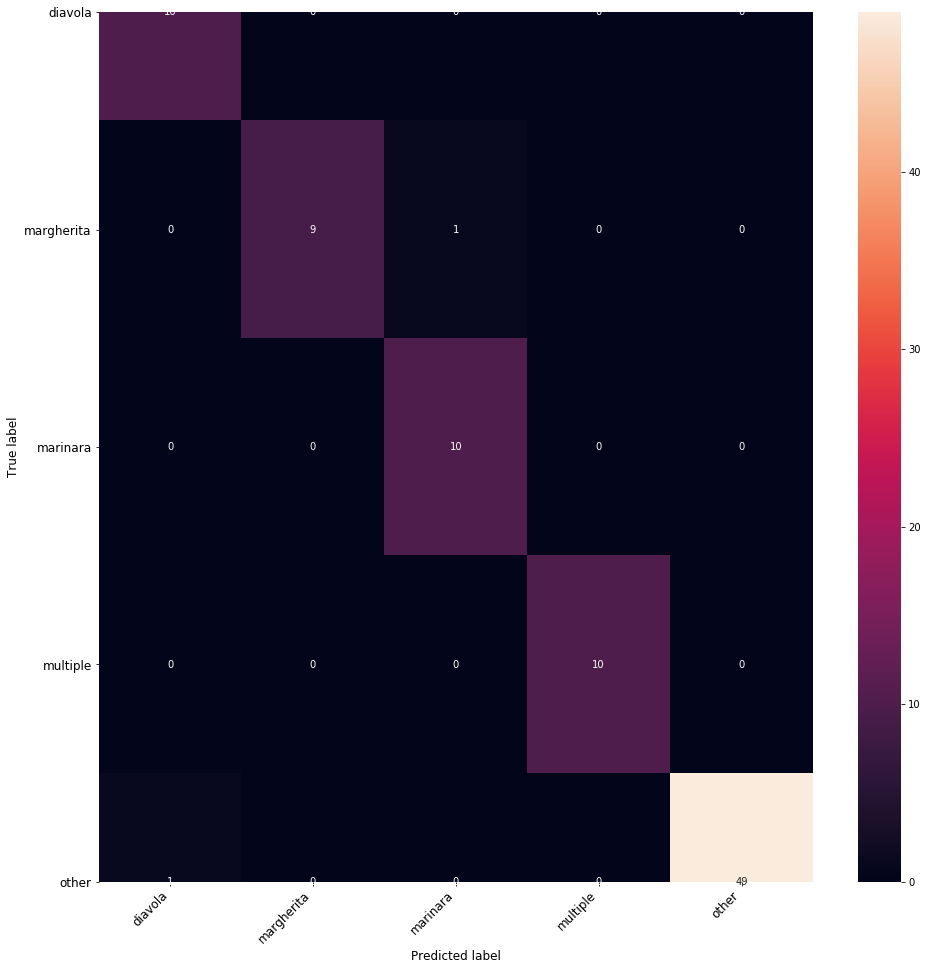

In [190]:
labels = test_data["label"].unique().sort()
conf = compute_confusion_matrix(metrics, labels)
plot_confusion_matrix(conf, labels, figsize=(16, 16))

In [191]:
for i, label in enumerate(labels):
    correct = conf[i, i]
    images_per_class = conf[i].sum()
    print("%10s %.1f%%" % (label, 100. * correct/images_per_class))

   diavola 100.0%
margherita 90.0%
  marinara 100.0%
  multiple 100.0%
     other 98.0%


In [192]:
class2index = {v:k for k,v in enumerate(test_data["label"].unique().sort())}
predicted_labels = np.argmax(predictions, axis=-1)
target_labels = list(map(lambda l: class2index[l], test_data["label"]))

In [193]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(np.array(predictions), axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {k:v for k,v in enumerate(test_data["label"].unique().sort())}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f" % (test_data["path"][i],
                                             index2class[predicted_labels[i]],
                                             probs_max[i]))

../../data/test/margherita/82f9b8f661cad841407f2a400597cbac.jpg was predicted as 'marinara' 0.4094
../../data/test/other/9002s2VnOAY.jpg was predicted as 'diavola' 0.3777


# Convertion

In [194]:
model.save("Pizza_tc.model")

In [195]:
model.export_coreml("Pizza_tc.mlmodel")